# Final Project

### 獲取歷史資料

In [20]:
from finlab.data import Data
from finlab_old.data import Data as data1
import pandas as pd
import sqlite3
import os
import numpy as np

conn = sqlite3.connect(os.path.join('data', 'data.db'))
pd = pd.read_sql('select * from legal_person',conn,index_col = ['date'])
## 上面沒有整理

data1 = data1()


data = Data()

big = data1.get('三大法人買賣超股數',10000000).fillna(0)
#big0 = data1.get('外陸資買賣超股數(不含外資自營商)',10000000).fillna(0)
#le0 = data1.get('外資買進股數',10000000).fillna(0)
#le1 = data1.get('投信買進股數',10000000).fillna(0)
#le3 = data1.get('三大法人買超股數',10000000).fillna(0)
#bigm = big.rolling(3).sum()
rev = data.get("當月營收")
close = data.get("收盤價")
pbe = data.get('股價淨值比')
pe = data.get('本益比')
rev.index = rev.index.shift(5, "d")
#total = big0+big



In [3]:
##資料整理
##買進
big00 = data1.get('外資自營商買進股數',10000000).fillna(0)
big01 = data1.get('外資買進股數',10000000).fillna(0)
big02 = data1.get('外陸資買進股數(不含外資自營商)',10000000).fillna(0)
big03 = data1.get('投信買進股數',10000000).fillna(0)
big04 = data1.get('自營商買進股數',10000000).fillna(0)
big05 = data1.get('自營商買進股數(自行買賣)',10000000).fillna(0)
big06 = data1.get('自營商買進股數(避險)',10000000).fillna(0)

In [4]:
big1 = big00+big01+big02+big03+big04+big05+big06

In [5]:

con1 = big > 0
con2 = big.shift(1) > 0 
con3 = big.shift(2) > 0
con4 = big.shift(3) > 0
condition1 = con1 & con2 & con3 & con4

### 計算features

In [21]:
def legal(n):
    legal = big.rolling(n,min_periods=1).sum()
    #legal = legal.replace([np.inf, -np.inf], np.nan).fillna(0)
    return legal


def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

features = {
    'mom1': mom(1),
    'mom2': mom(2),

    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
    'pe':pe,
    'pbe':pbe,
    
    

    
}
 #  'legal5':legal(5),
 #  'legal10':legal(10),
 #  'legal20':legal(20),
 #  'legal60':legal(60),
 #  'legal120':legal(120),
 #  'legal240':legal(240),
  #  'rsv5': rsv(5),
  #  'rsv10': rsv(10),
  #  'rsv20': rsv(20),
  #  'rsv60': rsv(60),
  #  'rsv120': rsv(120),
  #  'rsv240': rsv(240),
   # 'big1':big1,
   # 'big2':big2,
   # 'big3':big3,
 #       'mom3': mom(3),
  #  'mom4': mom(4),
  #  'mom5': mom(5),
  #  'mom6': mom(6),
  #  'mom7': mom(7),
  #  'mom8': mom(8),
  #  'mom9': mom(9),

### 製作dataset

##### 設定買賣頻率

In [22]:
every_day = close.index
every_day = every_day[-392:]

##### 將dataframe 組裝起來

In [23]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_day, method='ffill')

In [24]:

for name, f in features.items():
    features[name] = f.unstack()

In [25]:
import pandas as pd
dataset = pd.DataFrame(features)

In [26]:
feature_names = list(dataset.columns)

### 新增 label

In [27]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

In [28]:
import sklearn.preprocessing as preprocessing
dataset_scaled = pd.DataFrame(preprocessing.scale(dataset),index = dataset.index , columns = dataset.columns)
dataset_scaled["return"] = dataset["return"]
dataset_scaled["rank"] = dataset["rank"]
# 可以把其他東西放回來 除了以下這些
#dataset['pe'] = dataset['pe'].rank(pct=True)
#dataset['pbe'] = dataset['pbe'].rank(pct=True)
#dataset['legal5'] = dataset['legal5'].rank(pct=True)
#dataset['legal10'] = dataset['legal10'].rank(pct=True)
#dataset['legal20'] = dataset['legal20'].rank(pct=True)
#dataset['legal60'] = dataset['legal60'].rank(pct=True)
#dataset['legal120'] = dataset['legal120'].rank(pct=True)
#dataset['legal240'] = dataset['legal240'].rank(pct=True)
#dataset['big2'] = dataset['big2'].rank(pct=True)
#dataset['big3'] = dataset['big3'].rank(pct=True)

### 刪除太大太小的歷史資料

In [30]:
print(dataset.shape)

dataset = ml.drop_extreme_case(dataset_scaled, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2']
                               ,thresh=0.01)
#, 'mom3', 'mom4', 'mom5', 'mom6'
print(dataset.shape)


(756168, 24)
(714546, 24)


In [31]:
dataset_dropna = dataset.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [32]:
dataset_train = dataset_dropna[:'2018']
dataset_test = dataset_dropna['2019':]

### 神經網路模型

In [33]:
import keras
from keras.initializers import he_normal
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dropout(0.95))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               2300      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 12,501
Trainable params: 12,501
Non-trainable params: 0
_________________________________________________________________
start fitting
Train on 235067 samples, validate on 26119 samples
Epoch 1/225
235067/235067 [==============================] - 2s 9us/step - loss: 0.0902 - val_loss: 0.0718
Epoch 2/225
235067/235067 [==============================] - 2s 7us/step - loss: 0.0750 - val_loss

### 結果

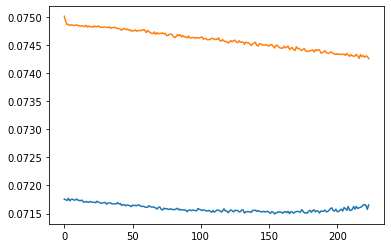

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [35]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

In [ ]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [ ]:
vals1 = model.predict(dataset_test[feature_names].astype(float))
dataset_test['result1'] = pd.Series(vals1.swapaxes(0,1)[0], dataset_test.index)

vals2 = cf.predict(dataset_test[feature_names].astype(float))
dataset_test['result2'] = pd.Series(vals2, dataset_test.index)

vals3 = cf2.predict(dataset_test[feature_names].astype(float))
dataset_test['result3'] = pd.Series(vals3, dataset_test.index)


## 原本的

In [ ]:
import math


dates = sorted(list(set(dataset_test.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_test.loc[d]
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates).cumprod()

s0050 = close['0050']['2019':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()

In [103]:
def leg(n1,n3):
    condition1 = big.rolling(n1).sum() >n3*1000

In [173]:

## 組合學習評分策略

def rs(n1):
    dates = sorted(list(set(dataset_test.index)))
    rs = []
    for d in dates:
        
        dataset_time = dataset_test.loc[d]
        rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
            
        condition = (rank >= rank.nlargest(n1).iloc[-1]) 
        r = dataset_time['return'][condition].mean()
    
        rs.append(r * (1-3/1000-1.425/1000*2*0.6))
            
    rs = pd.Series(rs, index=dates).cumprod()
    return rs,condition

In [181]:
for i in range(1,10,1):
    
    a,c = rs(i)

## 添加三大反人條件

Total profit:


1.2718353962114084

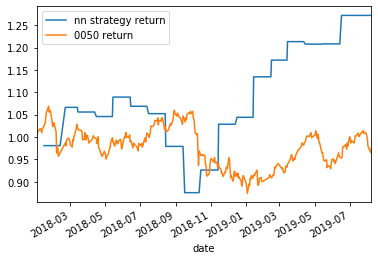

In [152]:
import math
rs,condition = rs(20)
s0050 = close['0050']['2018':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()
print("Total profit:")
rs[-1]

In [182]:
rmax = 0
for i in range(1,50,1):
    r,l = rs(i)
    rsn = r[-1]
    if rmax<rsn:
        rmax = rsn
        print(rmax,i)


1.0613876841385876 1
1.3468247708249879 2
1.357506972165442 3
1.387197313873605 5


In [159]:
        # 開始蝦七八亂改
    rk = dataset_time[condition]['stock_id']
    rd = []
    for n in rk:
        rd.append(n)
    
    condition1 = big.rolling(5).sum() >10*1000
    con = pd.DataFrame(condition1.unstack()[rd])
    con1 = con.pivot_table(index="stock_id",columns="date")
    con0 = con.pivot_table(index="date",columns="stock_id")
    con01 = con0.reindex(every_month, method='ffill').dropna()
    con02 = con01.loc[d][0]
    con03 = con02[con02]
    con04=[]
    for i in con03.index:
        con04.append(i)
            
    test = dataset_time.reset_index().set_index("stock_id")
    lo = test["return"][con04].mean()
        #lo = lo.dropna()
        
         #結束蝦七八亂改

IndentationError: unexpected indent (<ipython-input-159-f6dc56d1b03c>, line 2)

Total profit:


1.2023702501072853

In [28]:
rs[-1]**(1/3.5)

1.2035450653976612

### 當月持股狀況

stock_id  date      
1201      2019-08-15    1.505489
1434      2019-08-15    1.535945
1707      2019-08-15    1.406626
2206      2019-08-15    1.502443
2236      2019-08-15    1.473526
2404      2019-08-15    1.489815
2812      2019-08-15    1.598333
2832      2019-08-15    1.662192
2845      2019-08-15    1.690368
2849      2019-08-15    1.498570
2891      2019-08-15    1.452448
4722      2019-08-15    1.516161
5706      2019-08-15    1.450519
6189      2019-08-15    1.508385
8081      2019-08-15    1.399126
8481      2019-08-15    1.552472
9911      2019-08-15    1.667698
dtype: float64

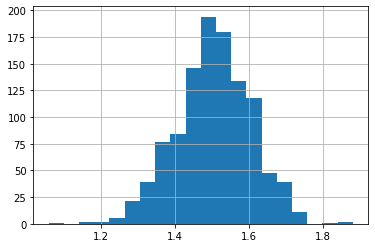

In [87]:
# get the latest dataset

last_date = dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


# remove NaN testcases

#print("Some stocks are skipped due to NaN")
#print(last_dataset[last_dataset[feature_names].isnull().sum(axis=1) != 0].index.get_level_values("stock_id").values)
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks


stock_id  date      
1533      2019-08-15    1.740019
1540      2019-08-15    1.713157
1541      2019-08-15    1.756575
1762      2019-08-15    1.882149
2107      2019-08-15    1.722287
2377      2019-08-15    1.722419
2643      2019-08-15    1.714698
2834      2019-08-15    1.750045
2851      2019-08-15    1.713711
2904      2019-08-15    1.742230
3005      2019-08-15    1.747282
3702      2019-08-15    1.718035
4402      2019-08-15    1.708829
5215      2019-08-15    1.708671
5289      2019-08-15    1.727369
5291      2019-08-15    1.728467
5493      2019-08-15    1.720125
6023      2019-08-15    1.716572
6289      2019-08-15    1.862858
8420      2019-08-15    1.818211
dtype: float64

In [ ]:
from finlab_old.data import Data
data = Data()
big = data.get('三大法人買賣超股數',10000000)

big = big.fillna(0)
bigm = big.rolling(3).sum()
condition1 = (big - bigm)>3*1000

big.reindex(every_month, method='ffill').unstack()
big = pd.DataFrame(big)
big = big.dropna(how='any')
big = big.reset_index().set_index("date")

## 小結論

In [ ]:
con = pd.DataFrame(condition1.unstack()[rd])
con1 = con.pivot_table(index="stock_id",columns="date")
con0 = con.pivot_table(index="date",columns="stock_id")
con1 = con1[0]
con2 = con1["2012-05-25"]

test = dataset_time.reset_index().set_index("stock_id")
test["return"][rd]
con3 = con2[con2].index
con4 = []
for i in con3:
    con4.append(i)
#con4

#test["return"][con4]#.mean()  #成功選出我們所需要的股票

In [ ]:
con01 = con0.reindex(every_month, method='ffill').dropna()
con02 = con01.loc[d][0]
con03 = con02[con02]

con04=[]
for i in con03.index:
    con04.append(i)
if con04!=[]:
    lo = test["return"][con04]
    print(lo)

In [ ]:
import datetime
from finlab.crawler import date_range
#condition1.unstack()[rd]
d= condition1.unstack()[rd].reset_index().set_index("date")
#d = d['2012-05-10']
#d.reindex(every_month, method='ffill')
#new_m = every_month[87:]
#d.reindex(new_m, method='ffill')
new_m = date_range(datetime.date(2012,5,10),datetime.date(2019,8,3))
d.columns
